In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score
from pycaret.classification import *

In [2]:
seed = 42
np.random.seed(seed)
set_config('seed', seed)

# 1. 데이터 로드

In [3]:
train=pd.read_csv('input/train.csv', index_col=0) #인덱스 col=0도 check!
test=pd.read_csv('input/test.csv', index_col=0)
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [4]:
train['income']=pd.factorize(train['income'], sort=True)[0]

In [5]:
train.shape, test.shape

((26049, 15), (6512, 14))

In [ ]:
train.head(3)
test.head(3)

# 2. EDA & 전처리

In [ ]:
train.info()
train.describe()
train.describe(include='O')

## Missing Value

In [ ]:
train.isnull().sum().sum()
test.isnull().sum().sum()

### outlier

### education

In [6]:
train.drop(['education'],axis=1, inplace=True)
test.drop(['education'],axis=1, inplace=True)

### capital_gain 99999

In [7]:
df = pd.concat([train, test])

df['capital_gain_imsi'] = df['capital_gain'].replace(99999,0)

capital_gain_imsi = pd.DataFrame(df.groupby(['education_num'])['capital_gain_imsi'].mean()).reset_index()

train = train.merge(capital_gain_imsi, on=['education_num'], how='left')
test = test.merge(capital_gain_imsi, on=['education_num'], how='left')

train.loc[train.capital_gain == 99999, 'capital_gain'] = train['capital_gain_imsi']
test.loc[test.capital_gain == 99999, 'capital_gain'] = test['capital_gain_imsi']

train.drop(['capital_gain_imsi'],axis=1, inplace=True)
test.drop(['capital_gain_imsi'],axis=1, inplace=True)

In [26]:
train['Priority'] = 0


train.loc[((train['occupation'] == 'Exec-managerial')&(train['workclass'] == 'Self-emp-inc')), 'Priority'] = 8

train.loc[((train['workclass'] == 'Federal-gov')*(train['occupation'] == 'Prof-specialty')), 'Priority'] = 7

train.loc[  ((train['workclass'] == 'Local-gov') | (train['workclass'] == 'Self-emp-not-inc'))
          & ((train['occupation'] == 'Protective-serv') | (train['occupation'] == 'Tech-support'))
          , 'Priority'] = 6

train.loc[((train['workclass'] == 'State-govv') & (train['occupation'] == 'Sales')), 'Priority'] = 5

train.loc[(
           (train['workclass'] == 'Private') & ((train['occupation'] == 'Craft-repair')
                                                |(train['occupation'] == 'Transport-moving'))
           ), 'Priority'] = 4

train.loc[((train['occupation'] == 'Adm-clerical') 
           | (train['occupation'] == 'Machine-op-inspct') 
           | (train['occupation'] == 'Farming-fishing')), 'Priority'] = 3

train.loc[((train['workclass'] == '?') & (train['occupation'] == '?')), 'Priority'] = 2
train.loc[((train['occupation'] == 'Handlers-cleaners') 
           | (train['occupation'] == 'Other-service') 
           | (train['occupation'] == 'Priv-house-serv')), 'Priority'] = 1
train.loc[(
    ((train['workclass'] == 'Never-worked')
    | (train['workclass'] == 'Without-pay'))
    & (train['occupation'] == 'Armed-Forces')), 'Priority'] = 0

In [27]:
test['Priority'] = 0


test.loc[((test['occupation'] == 'Exec-managerial')&(test['workclass'] == 'Self-emp-inc')), 'Priority'] = 8

test.loc[((test['workclass'] == 'Federal-gov')*(test['occupation'] == 'Prof-specialty')), 'Priority'] = 7

test.loc[  ((test['workclass'] == 'Local-gov') | (test['workclass'] == 'Self-emp-not-inc'))
          & ((test['occupation'] == 'Protective-serv') | (test['occupation'] == 'Tech-support'))
          , 'Priority'] = 6

test.loc[((test['workclass'] == 'State-govv') & (test['occupation'] == 'Sales')), 'Priority'] = 5

test.loc[(
           (test['workclass'] == 'Private') & ((test['occupation'] == 'Craft-repair')
                                                |(test['occupation'] == 'Transport-moving'))
           ), 'Priority'] = 4

test.loc[((test['occupation'] == 'Adm-clerical') 
           | (test['occupation'] == 'Machine-op-inspct') 
           | (test['occupation'] == 'Farming-fishing')), 'Priority'] = 3

test.loc[((test['workclass'] == '?') & (test['occupation'] == '?')), 'Priority'] = 2
test.loc[((test['occupation'] == 'Handlers-cleaners') 
           | (test['occupation'] == 'Other-service') 
           | (test['occupation'] == 'Priv-house-serv')), 'Priority'] = 1
test.loc[(
    ((test['workclass'] == 'Never-worked')
    | (test['workclass'] == 'Without-pay'))
    & (test['occupation'] == 'Armed-Forces')), 'Priority'] = 0

# 3. 모델 학습

In [ ]:
import gc
gc.collect()

In [ ]:
train.columns

In [28]:
%%time
clf = setup(session_id=seed, 
            data = train, target = 'income'
          , categorical_features=['Priority']
          , numeric_features = ['education_num']
          #, ignore_features = ['fnlwgt']
           )

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(26049, 15)"
4,Missing Values,False
5,Numeric Features,6
6,Categorical Features,8
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 4 s


In [29]:
best_3 = compare_models(sort = 'F1', n_select = 3
                       ,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'ridge','qda']
                       #,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'xgboost']
                       )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Light Gradient Boosting Machine,0.8650,0.9210,0.6423,0.7630,0.6972,0.6112,0.6151,0.3614
1,Extreme Gradient Boosting,0.8643,0.9210,0.6442,0.7594,0.6968,0.6102,0.6138,2.9059
2,CatBoost Classifier,0.8659,0.9242,0.6335,0.7720,0.6956,0.6106,0.6158,14.3009
3,Gradient Boosting Classifier,0.8637,0.9183,0.6125,0.7775,0.6850,0.5997,0.6067,3.2639
4,Ada Boost Classifier,0.8572,0.9119,0.6183,0.7486,0.6770,0.5865,0.5910,0.9350
5,Linear Discriminant Analysis,0.8464,0.9004,0.5960,0.7214,0.6523,0.5549,0.5593,0.2336
6,Extra Trees Classifier,0.8338,0.8815,0.5992,0.6778,0.6359,0.5288,0.5306,0.6513
7,Random Forest Classifier,0.8393,0.8753,0.5555,0.7178,0.6260,0.5258,0.5330,0.1294


In [30]:
blended = blend_models(estimator_list = best_3, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8680,0.9223,0.6456,0.7718,0.7031,0.6191,0.6232
1,0.8613,0.9167,0.6472,0.7463,0.6932,0.6042,0.6068
2,0.8551,0.9224,0.6197,0.7394,0.6743,0.5820,0.5858
3,0.8734,0.9304,0.6321,0.8025,0.7072,0.6279,0.6352
4,0.8715,0.9238,0.6537,0.7799,0.7113,0.6294,0.6335
Mean,0.8659,0.9231,0.6397,0.7680,0.6978,0.6125,0.6169
SD,0.0068,0.0044,0.0122,0.0230,0.0132,0.0177,0.0185


In [31]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8748,0.9292,0.6594,0.7886,0.7182,0.6386,0.6428


In [32]:
%%time
final_model = finalize_model(blended)

Wall time: 4min 3s


In [33]:
predictions = predict_model(final_model, data = test)

# 4. 예측

In [34]:
submission['prediction'] = predictions['Label']

# 5. 제출

In [35]:
submission.to_csv('output/20201021-1.csv')

In [36]:
xgboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8747,0.9226,0.6343,0.8066,0.7101,0.6317,0.6391
1,0.8622,0.9146,0.6570,0.7436,0.6976,0.6088,0.6107
2,0.8598,0.9175,0.6570,0.7355,0.6940,0.6035,0.6051
3,0.8582,0.9144,0.6234,0.7471,0.6796,0.5895,0.5935
4,0.8472,0.9086,0.6117,0.7159,0.6597,0.5619,0.5648
5,0.8652,0.9305,0.6505,0.7585,0.7003,0.6141,0.6171
6,0.8754,0.9347,0.6472,0.8000,0.7156,0.6369,0.6428
7,0.8660,0.9227,0.6440,0.7654,0.6995,0.6141,0.6179
8,0.8613,0.9223,0.6440,0.7481,0.6922,0.6033,0.6061
9,0.8730,0.9218,0.6731,0.7732,0.7197,0.6382,0.6407


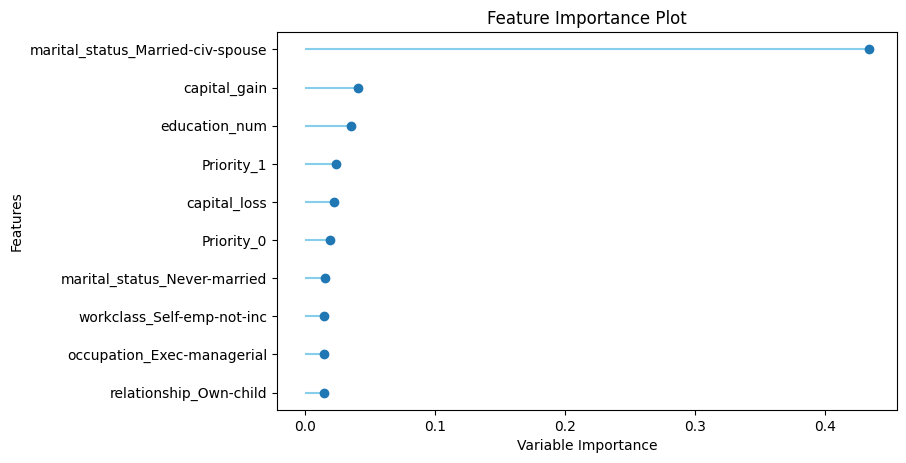

In [37]:
plot_model(estimator = xgboost, plot = 'feature')

In [38]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8669,0.9178,0.6375,0.7725,0.6986,0.6142,0.6188
1,0.8669,0.9196,0.6667,0.7546,0.7079,0.6221,0.6241
2,0.8567,0.9142,0.6505,0.7283,0.6872,0.5946,0.5962
3,0.8574,0.9164,0.6104,0.7520,0.6738,0.5838,0.5890
4,0.8558,0.9114,0.6343,0.7341,0.6806,0.5881,0.5907
5,0.8691,0.9332,0.6570,0.7689,0.7086,0.6248,0.6281
6,0.8777,0.9333,0.6602,0.8000,0.7234,0.6459,0.6508
7,0.8613,0.9202,0.6246,0.7598,0.6856,0.5977,0.6024
8,0.8668,0.9244,0.6149,0.7884,0.6909,0.6076,0.6153
9,0.8715,0.9197,0.6667,0.7715,0.7153,0.6329,0.6357


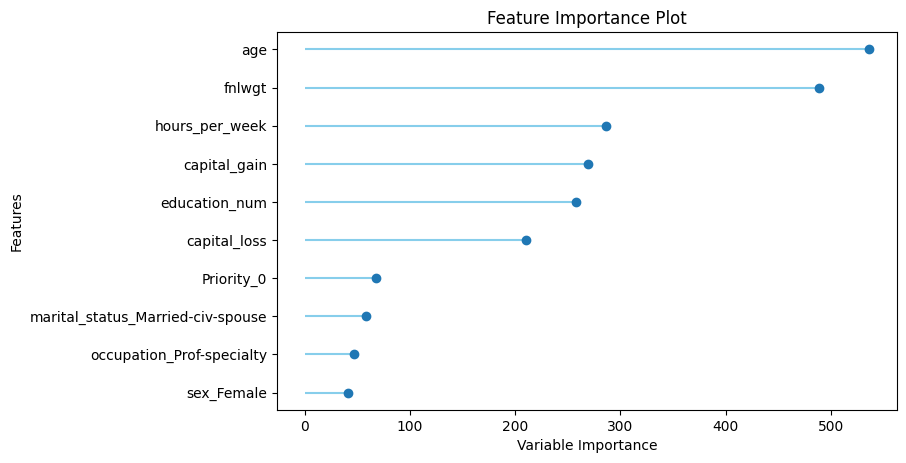

In [39]:
plot_model(estimator = lightgbm, plot = 'feature')